# Przetwarzanie i analiza danych obserwacji Ziemi w Pythonie
## W notatniku zawarto wszystkie komendy i funkcje związane z artykułem XYZ w czasopiśmie ZYX

Prezentowany kod pokazuje programistyczne podejście do przetwarzania danych z satelitów obserwacji Ziemi. W kodzie przetwarzan się dane z satelity Landsat 8, udostępniane przez USGS (https://www.usgs.gov/). Dane możliwe są do pobrania za pośrednictwem serwisu EarthExplorer (https://earthexplorer.usgs.gov/). Metadane przetwarzanej sceny znajdują się w oddzielnym pliku, najważniejszą kwestią jest poziom przetworzenia danych. Są one wstępnie przygotowane do analizy, ponieważ wyznaczono już współczynnik odbicia promieniowania w zakresie widzialnym i bliskiej podczerwieni (Level-2 Surface Reflectance). Więcej informacji o typie danych jak i o poszczególnych etapach ich przetwarzania w artykule XYZ, w czasopiśmie ZYX.

-----
Prawa autorskie: 

Licencja MIT
Copyright: Szymon Moliński
Użytkownik posiada nieograniczone prawo do używania, kopiowania, modyfikowania i rozpowszechniania (w tym sprzedaży) oryginalnego lub zmodyfikowanego programu w postaci binarnej lub źródłowej. Jedynym wymaganiem jest, by we wszystkich wersjach zachowano warunki licencyjne i informacje o autorze. Więcej informacji: https://opensource.org/licenses/mit-license.php


In [1]:
# Import podstawowych bibliotek

%matplotlib notebook
import os
import numpy as np
import rasterio as rio
import rasterio.mask as rmask
import fiona as fio
import matplotlib.pyplot as plt

In [2]:
# Funkcja do wczytywania listy kanalow i porzadkowania jej

def wczytaj_obrazy_landsat(nazwa_folderu):
    """Funkcja zwraca słownik (dict) z parami NUMER KANAŁU: ścieżka_do_pliku
    return: {numer_kanalu: sciezka_do_pliku}"""
    lista_plikow = os.listdir(nazwa_folderu)
    lista_kanalow = []
    for plik in lista_plikow:
        if (plik.startswith('LC') and plik.endswith('.tif')):
            if 'band' in plik:
                lista_kanalow.append(nazwa_folderu + plik)             
    lista_kanalow.sort()
    numery_kanalow = np.arange(1, 8)
    slownik_z_lista_kanalow = dict(zip(numery_kanalow, lista_kanalow))
    return slownik_z_lista_kanalow

# pliki = wczytaj_obrazy_landsat('LC081880252013080701T1-SC20180329040242/')

In [3]:
# Funkcja do wyświetlania poszczególnych obrazów

def wyswietl_obraz(obraz, mapa_kolorow='gray'):
    fig = plt.figure(figsize=(8,8))
    warstwa_obrazu = plt.imshow(obraz)
    warstwa_obrazu.set_cmap(mapa_kolorow)  # inne mapy kolorów: winter, viridis, plasma, PRGn
    plt.colorbar()

In [4]:
# Funkcja do wycinania fragmentów rastra na podstawie szablonu z pliku wektorowego

def wytnij_obszar(wektor_adres, raster_adres, adres_zapisu):
    
    adres_wektora = 'vector/krakow_krakowskie.shp'
    with fio.open(wektor_adres, 'r') as wektor_zrodlo:
        geometria = [feature["geometry"] for feature in wektor_zrodlo]

    with rio.open(raster_adres, 'r') as r_zrodlo:
        wyciety_obraz, transformacja = rmask.mask(r_zrodlo, geometria, crop=True)
        metadane_obrazu = r_zrodlo.meta.copy()
        
    metadane_obrazu.update({"driver": "GTiff",
                 "height": wyciety_obraz.shape[1],
                 "width": wyciety_obraz.shape[2],
                 "transform": transformacja})
    with rio.open(adres_zapisu, "w", **metadane_obrazu) as nowy_g_tiff:
        nowy_g_tiff.write(wyciety_obraz)

In [5]:
# Funkcja do obliczania wskaźników

def oblicz_wskaznik(kanal_a, kanal_b):
    wskaznik_licznik = (kanal_a - kanal_b)
    wskaznik_mianownik = (kanal_a + kanal_b)
    wskaznik_macierz = np.zeros(kanal_a.shape)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        wskaznik_macierz = wskaznik_licznik / wskaznik_mianownik
        wskaznik = np.nan_to_num(wskaznik_macierz)
        wskaznik[wskaznik > 1] = 0
    return wskaznik

<IPython.core.display.Javascript object>


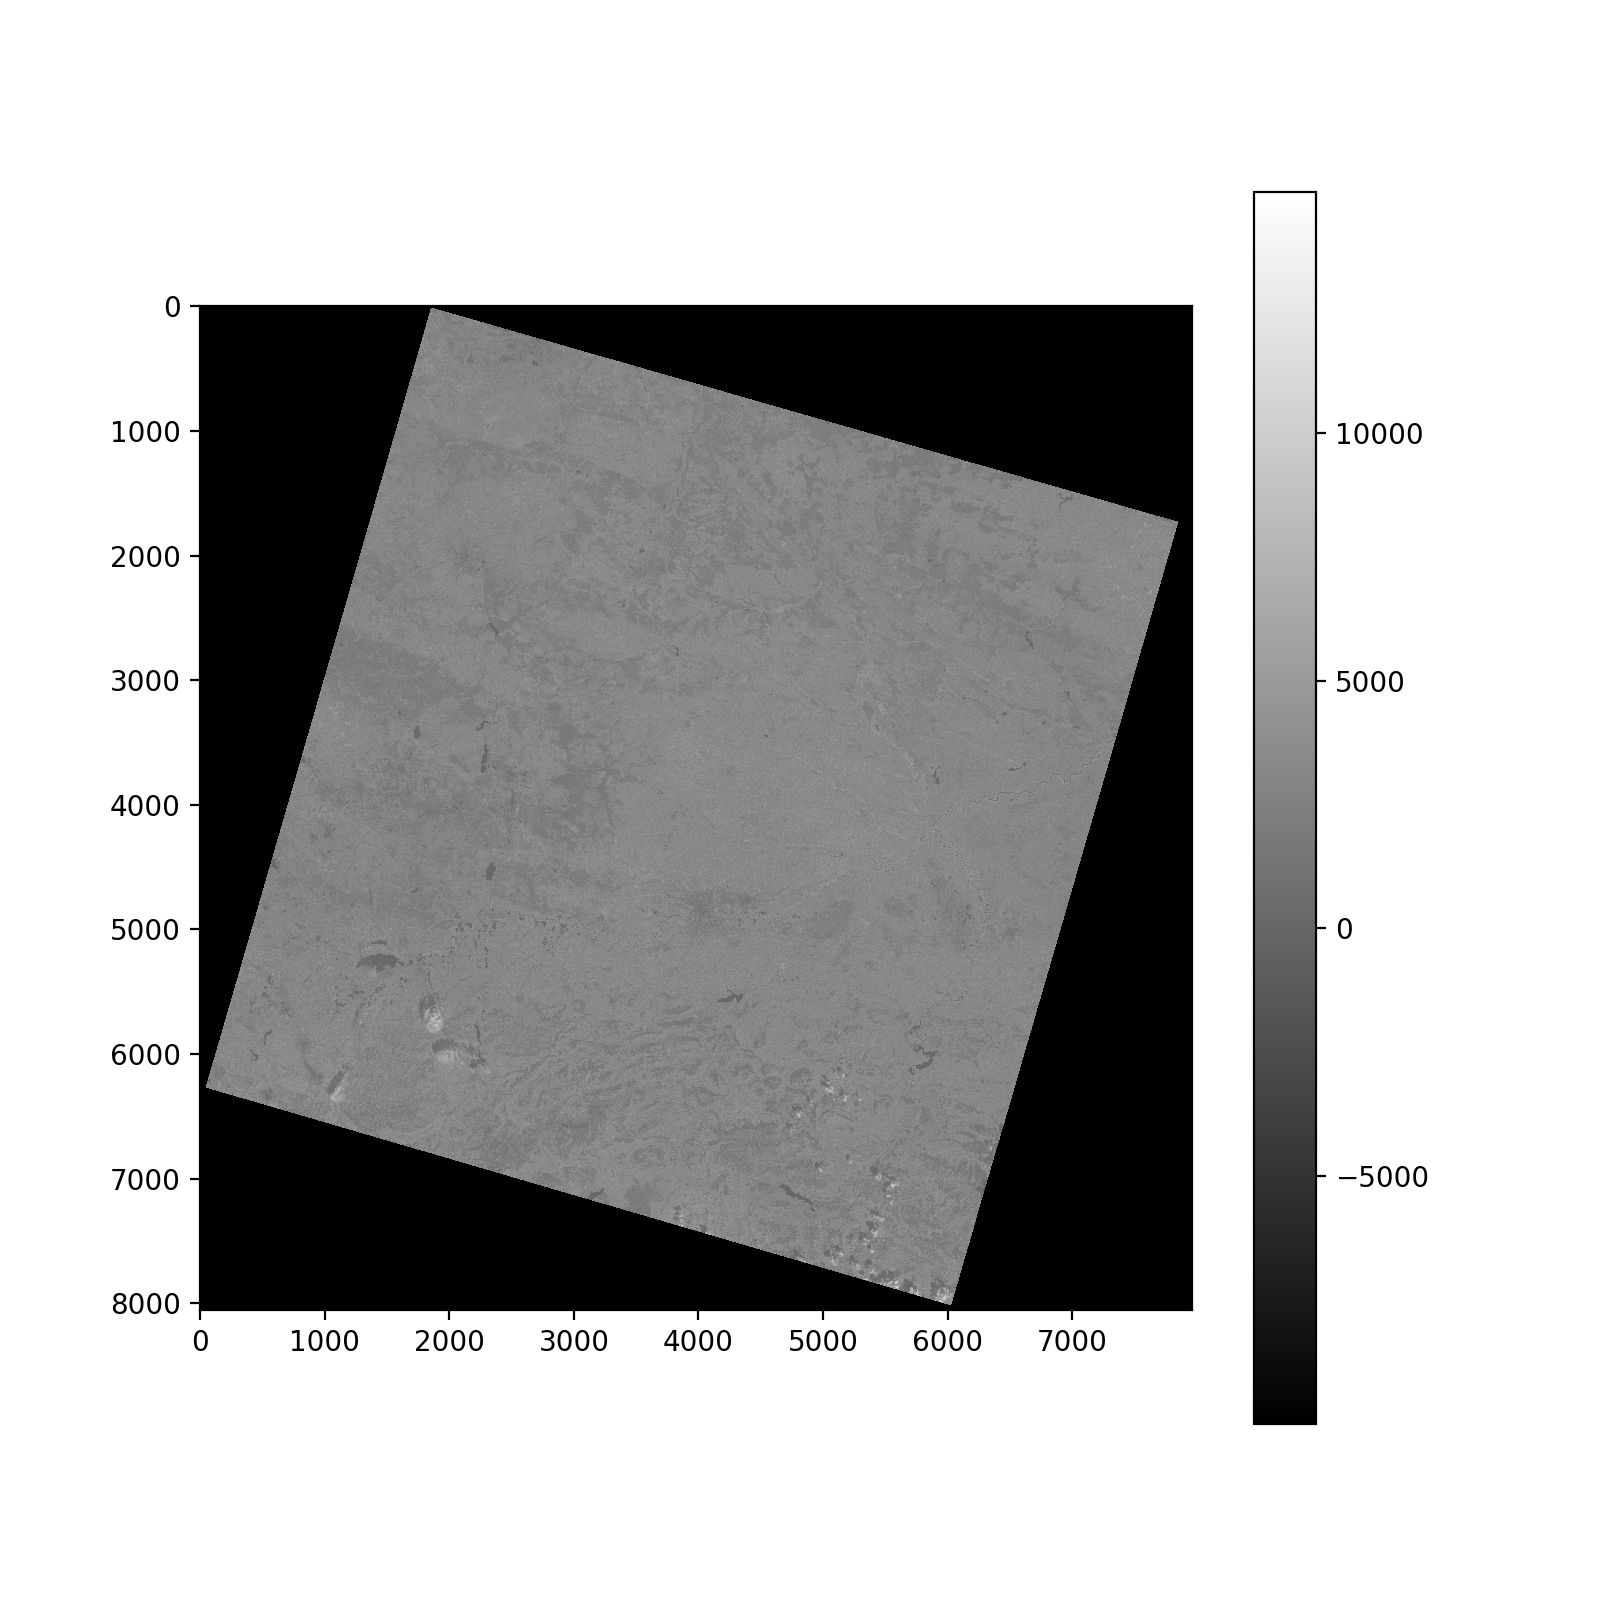

In [6]:
# Pierwsze kroki: wczytanie obrazu i jego wyświetlenie

plik_kanal_5 = 'LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band5.tif'
with rio.open(plik_kanal_5, 'r') as src:
    macierz_kanalu = src.read(1)

wyswietl_obraz(macierz_kanalu)

<IPython.core.display.Javascript object>


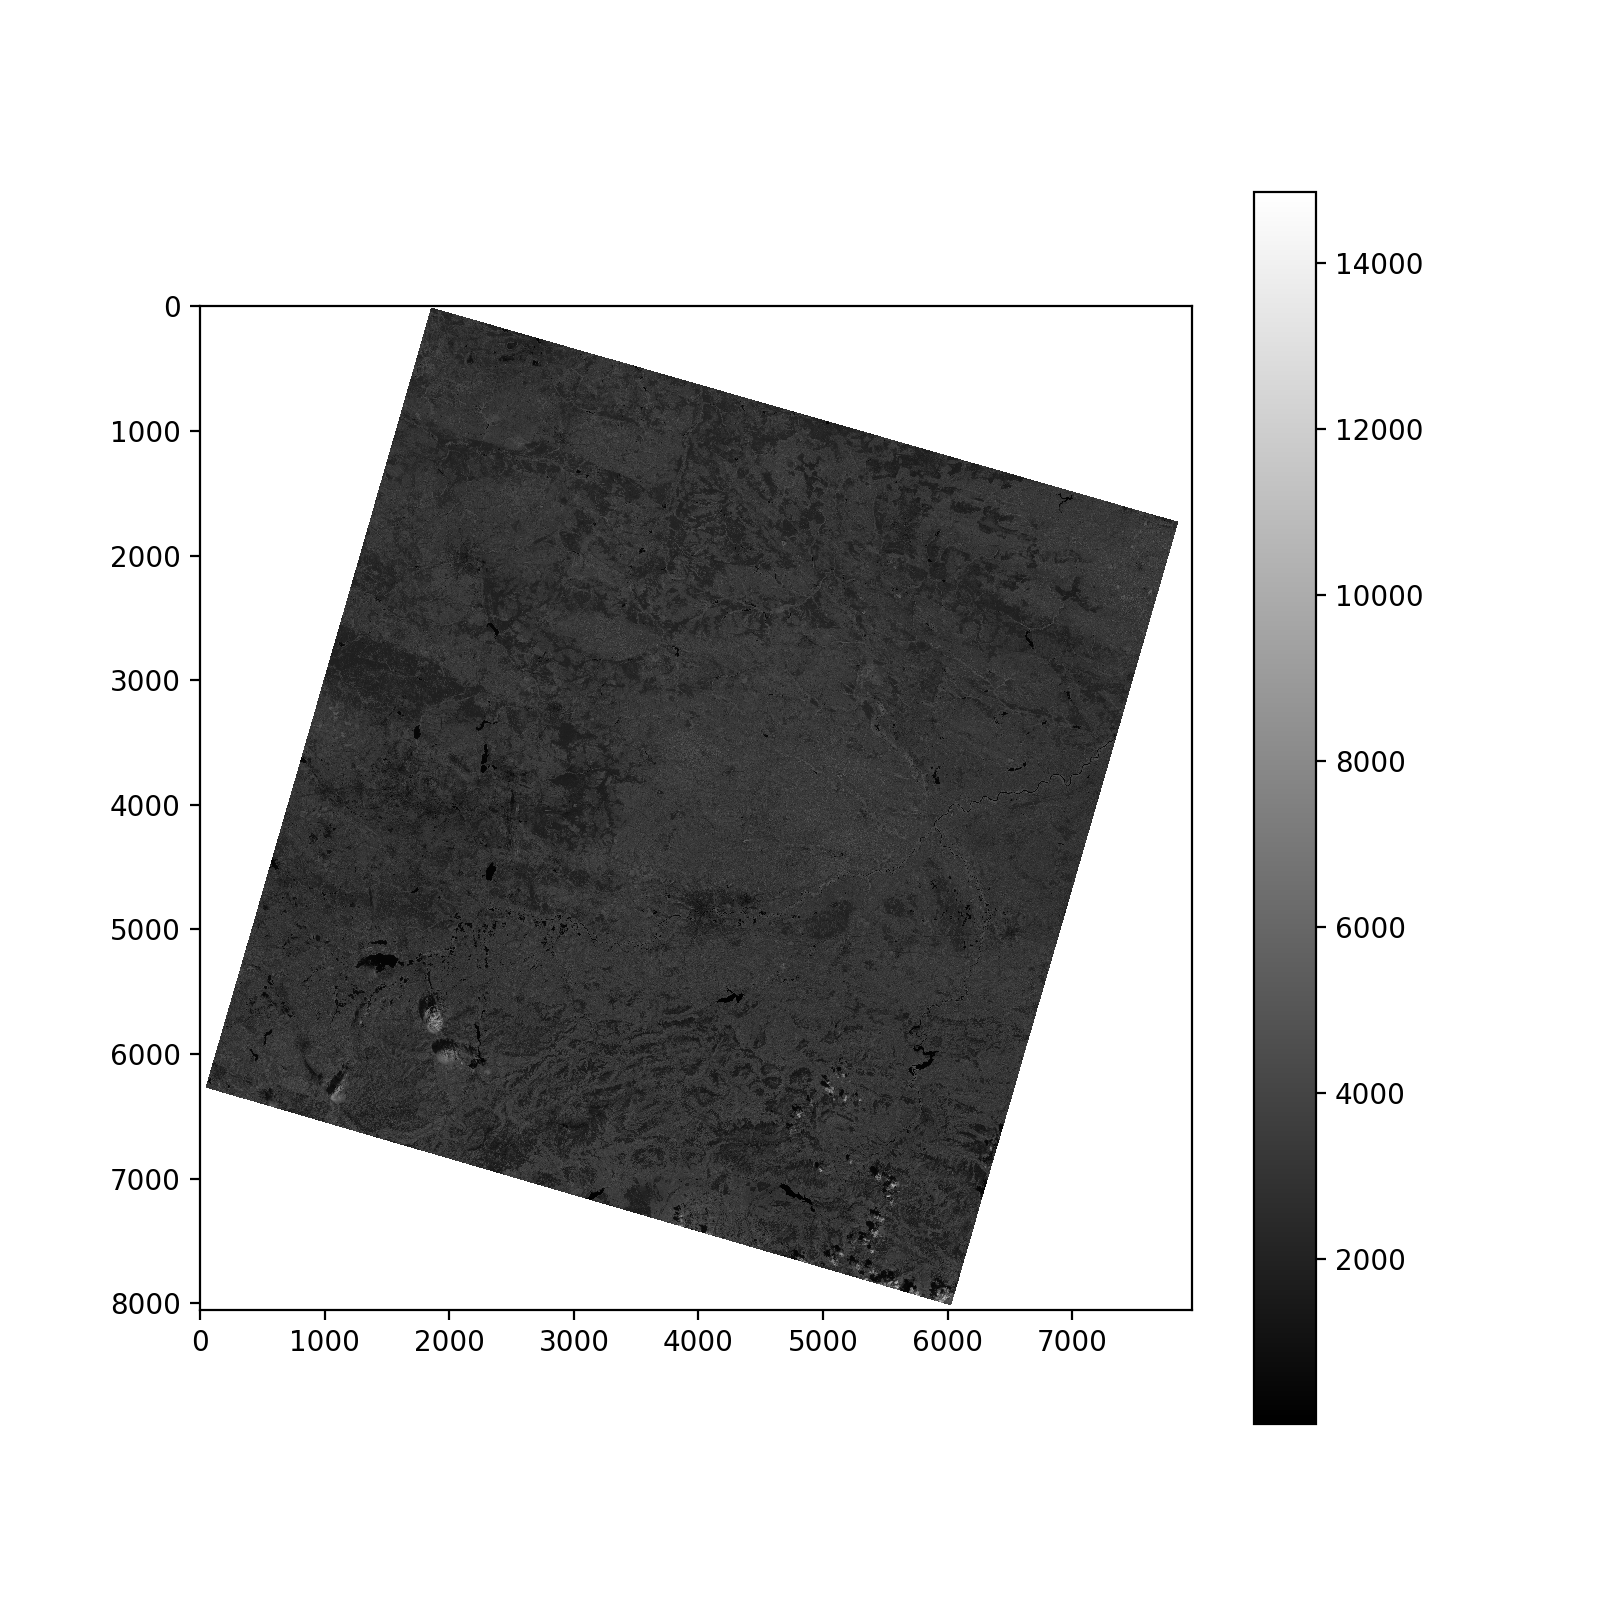

In [7]:
# Skąd wartości mniejsze niż zero? - oznaczają one niewypełnione piksele (NaN) i nie powinny być używane

macierz_bez_minus = macierz_kanalu.astype(float)
macierz_bez_minus[macierz_bez_minus < 0] = np.nan
wyswietl_obraz(macierz_bez_minus)

## Obszar zainteresowań ma znacznie

Zdjęcia satelitarne nie są przetwarzane "w całości" lecz z uwzględnieniem obszaru, dla którego prowadzimy obserwacje. O ile obszarem nie jest terytorium całej Polski, Europy albo świata, nie obrabia się tak dużych rastrów. Obszar zaintersowania można wyodrębnić na wiele sposobów, ale najbardziej użyteczne jest wykorzystywanie plików wektorów odwzorowujących granice administracyjne. Jednym problemem, któremu trzeba poświęcić szczególną uwagę, jest rodzaj projekcji danych. Funkcja wycinająca obszar zaintersowania musi też porównać typ projekcji między rastrem i wektorem. W przypadku niedopasowania projekcji, zawsze należy przetwarzać dane WEKTOROWE, ponieważ każda zmiana projekcji danych rastrowych skutkuje zniekształceniami wartości danych.

In [8]:
adres_wektora = 'vector/krakow_krakowskie.shp'
with fio.open(adres_wektora, 'r') as v_zrodlo:
    geometria = [feature["geometry"] for feature in v_zrodlo]

with rio.open(plik_kanal_5, 'r') as r_zrodlo:
    wyciety_obraz, transformacja = rmask.mask(r_zrodlo, geometria, crop=True)
    metadane_obrazu = r_zrodlo.meta.copy()

<IPython.core.display.Javascript object>


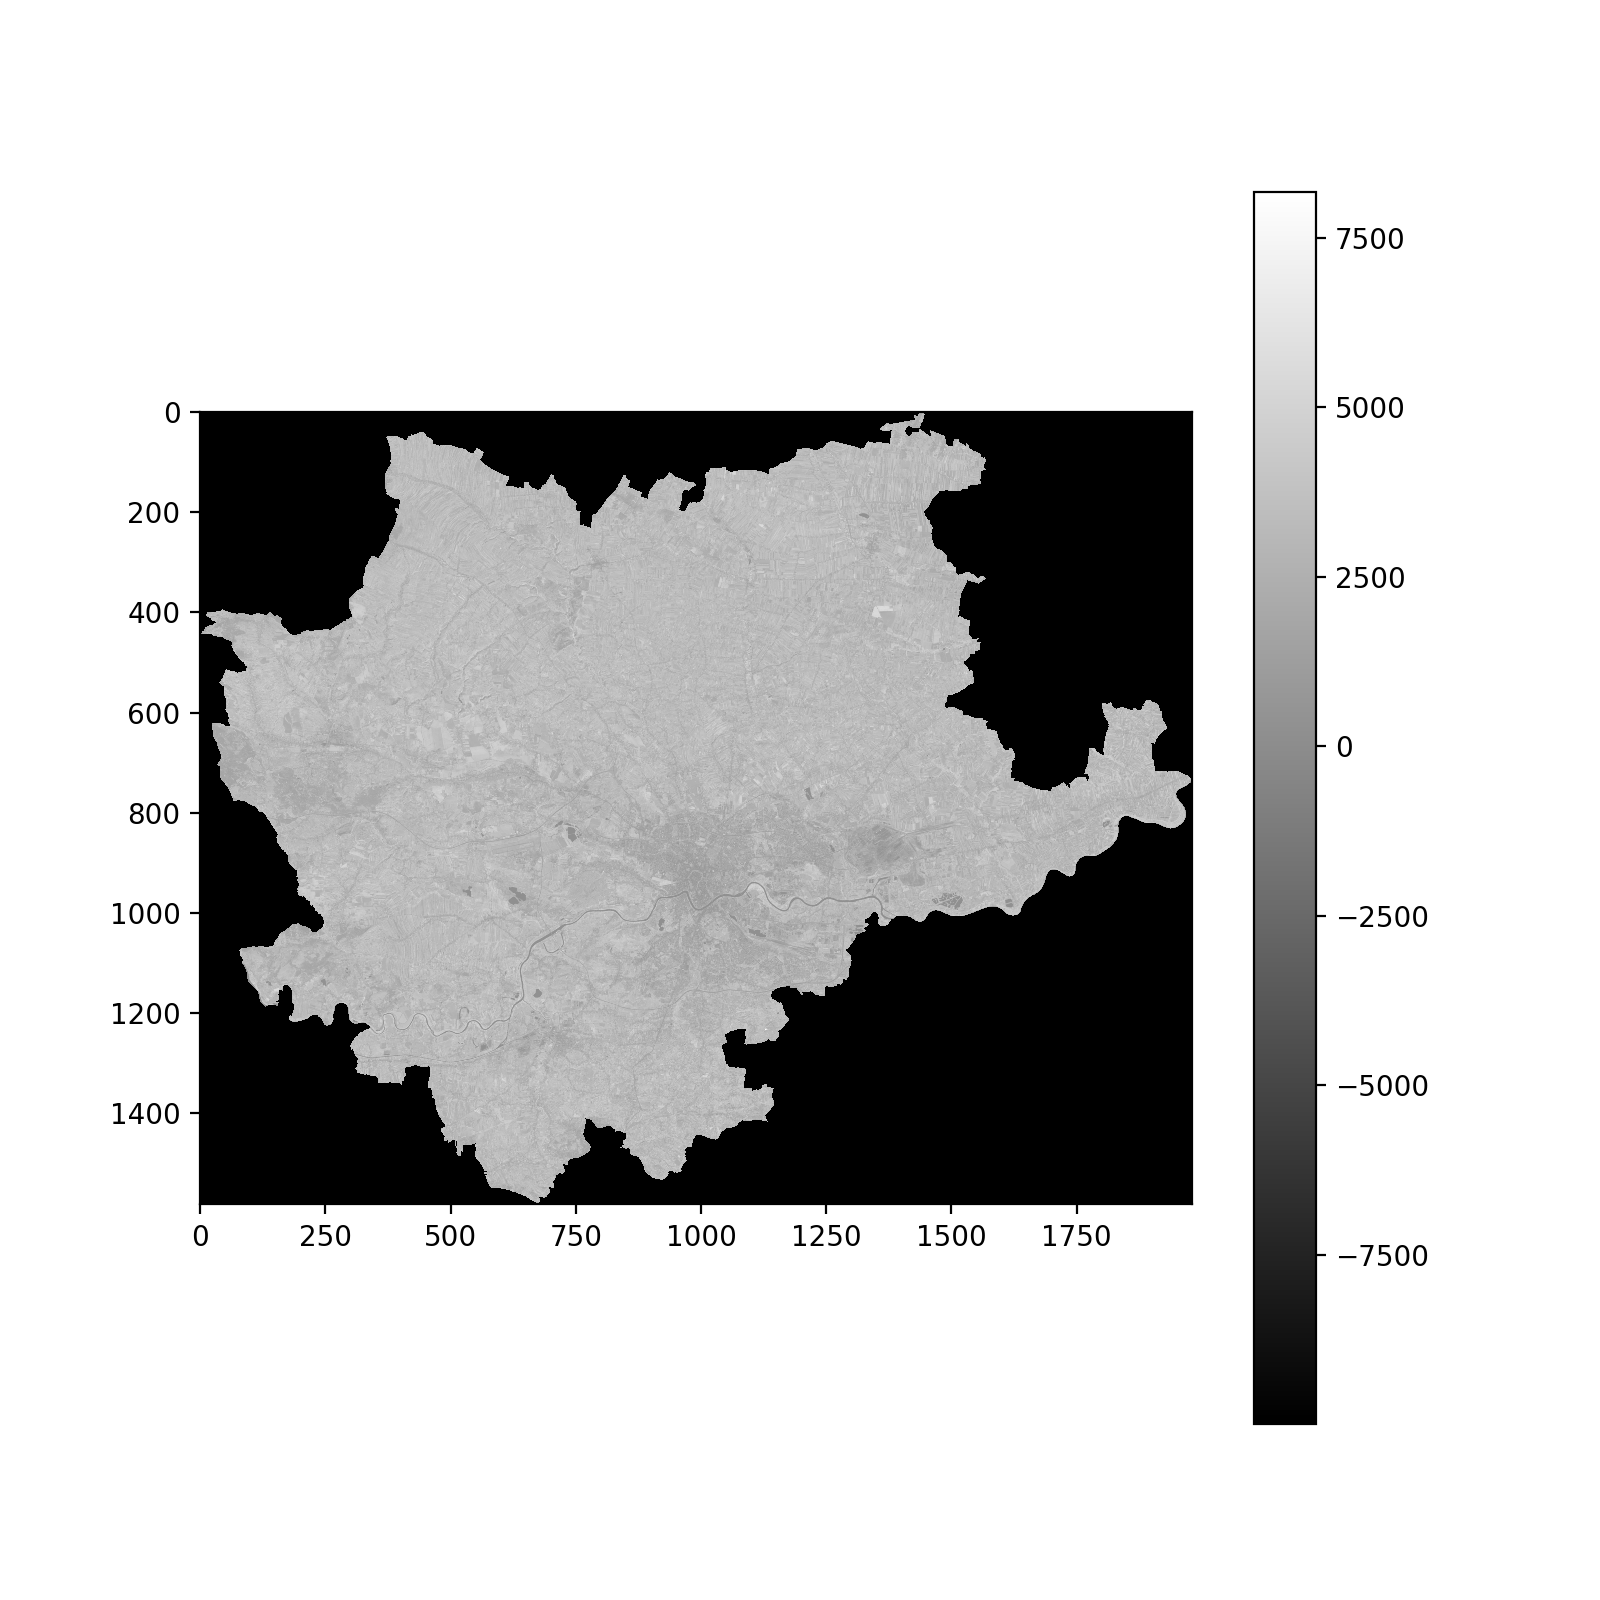

In [9]:
wyswietl_obraz(wyciety_obraz[0])

In [10]:
# Funkcja do wyświetlania poszczególnych obrazów - v 1.1

def wyswietl_obraz(obraz, mapa_kolorow='gray', usun_ujemne=True):
    if usun_ujemne:
        macierz = obraz.astype(float)
        macierz[macierz < 0] = np.nan
    fig = plt.figure(figsize=(8,8))
    warstwa_obrazu = plt.imshow(macierz)
    warstwa_obrazu.set_cmap(mapa_kolorow)  # inne mapy kolorów: winter, viridis, plasma, PRGn
    plt.colorbar()

<IPython.core.display.Javascript object>


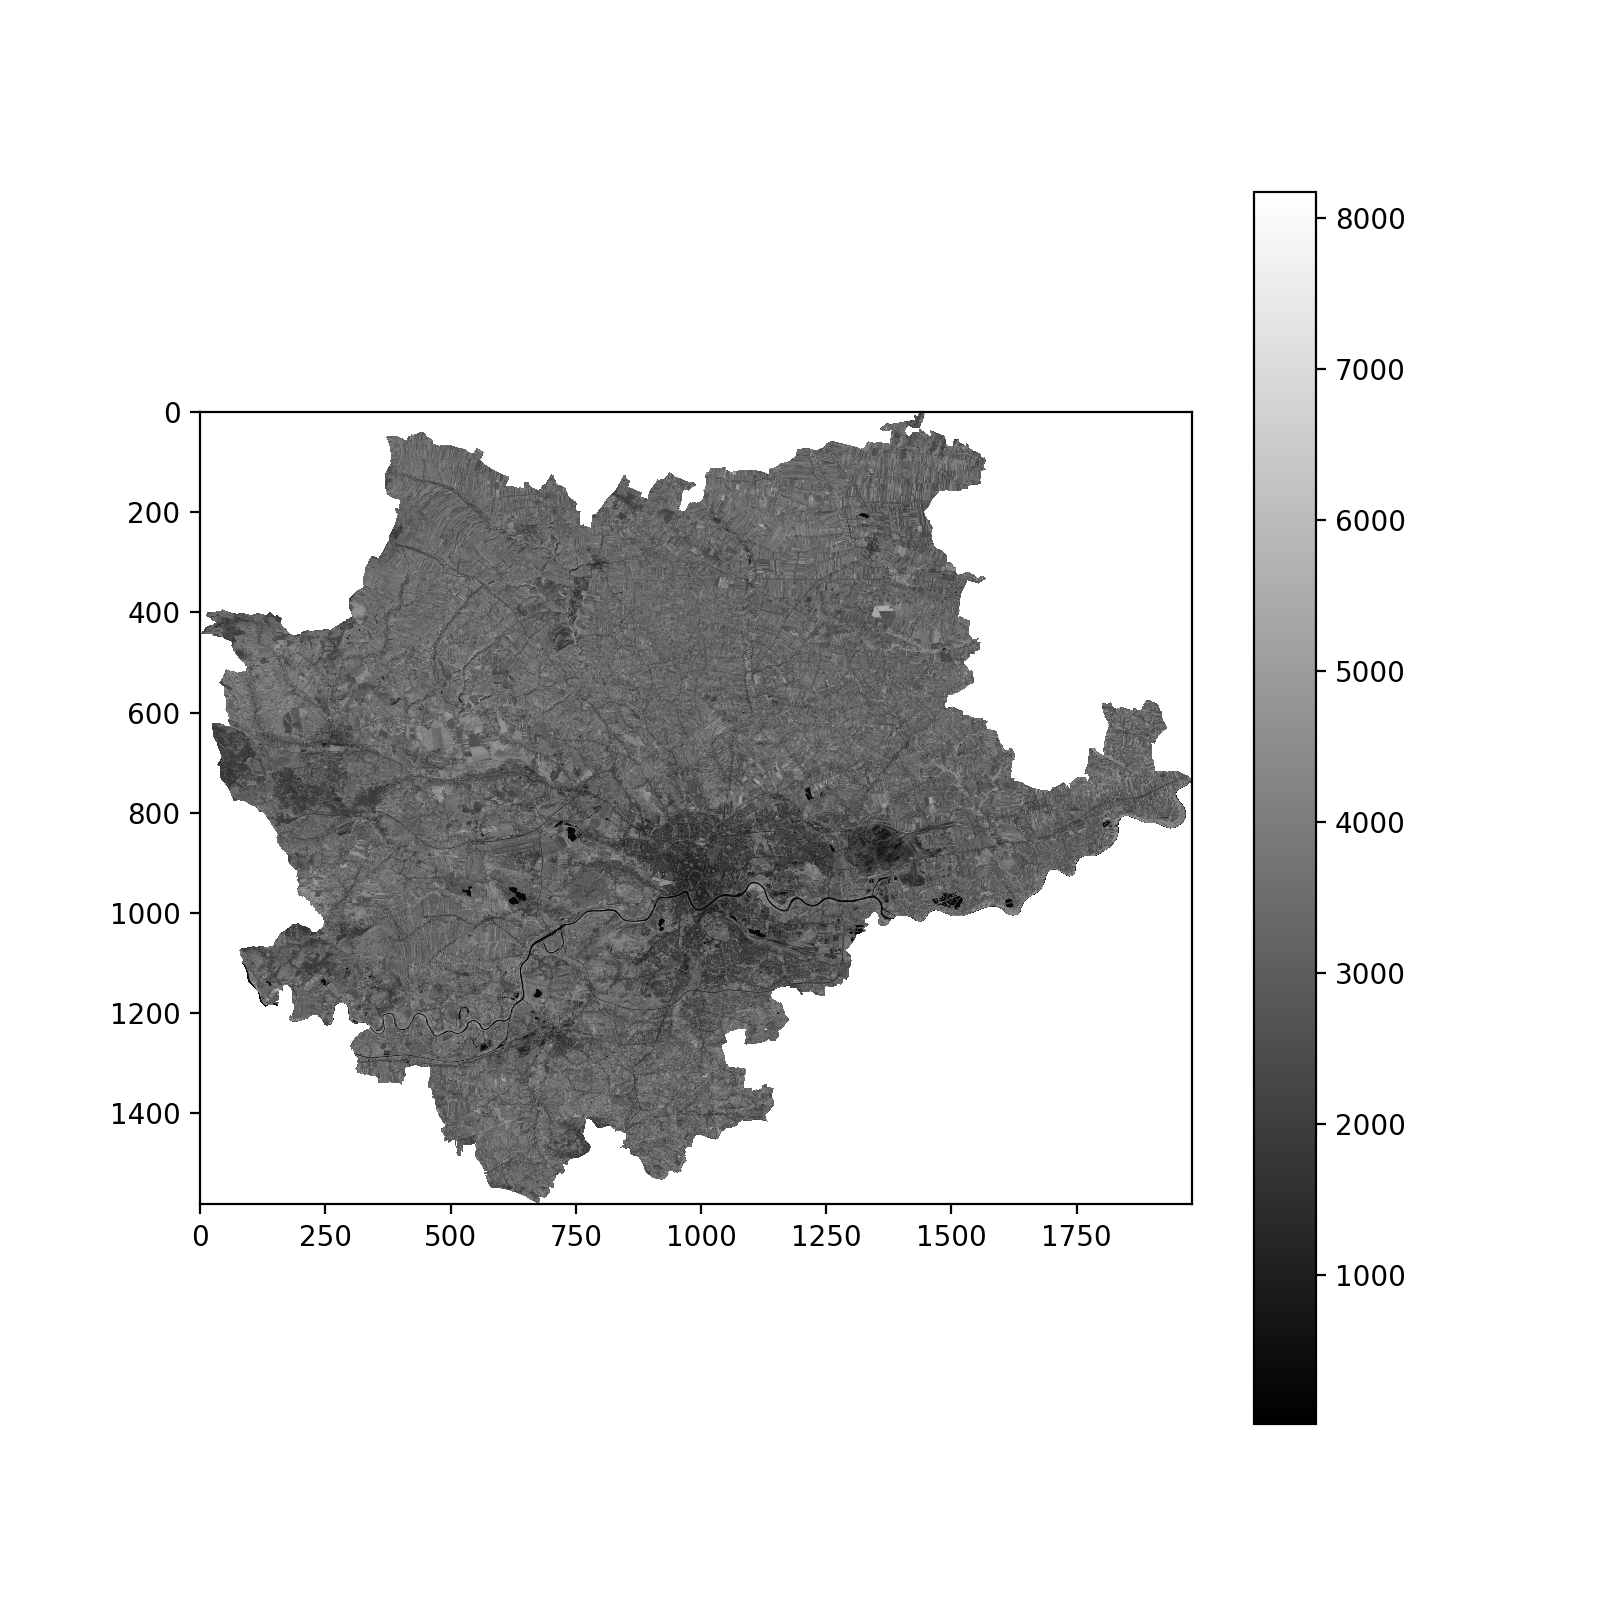

In [11]:
wyswietl_obraz(wyciety_obraz[0])

## Automatyzacja: od wczytania wszystkich obrazów, poprzez ich wycięcie, zapis do oddzielnego folderu i wyświetlenie

In [11]:
# 1. Wczytanie plików obrazów i sporządzenie ich listy

lista_obrazow = wczytaj_obrazy_landsat('LC081880252013080701T1-SC20180329040242/')
for kanal in lista_obrazow:
    print(lista_obrazow[kanal])

LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band1.tif
LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band2.tif
LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band3.tif
LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band4.tif
LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band5.tif
LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band6.tif
LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band7.tif


In [12]:
# 2. Wycięcie obszaru zainteresowania z każdego pliku

wektor = 'vector/krakow_krakowskie.shp'
wyciete = 'clipped/'
for kanal in lista_obrazow:
    miejsce_zapisu =wyciete + 'LC_clipped_band' + str(kanal) + '.tif'
    wytnij_obszar(adres_wektora, lista_obrazow[kanal], miejsce_zapisu)

In [13]:
# 3. Wczytanie listy przetworzonych plików

lista_wycietych_obrazow = wczytaj_obrazy_landsat('clipped/')
for kanal in lista_wycietych_obrazow:
    print(lista_wycietych_obrazow[kanal])

clipped/LC_clipped_band1.tif
clipped/LC_clipped_band2.tif
clipped/LC_clipped_band3.tif
clipped/LC_clipped_band4.tif
clipped/LC_clipped_band5.tif
clipped/LC_clipped_band6.tif
clipped/LC_clipped_band7.tif


<IPython.core.display.Javascript object>


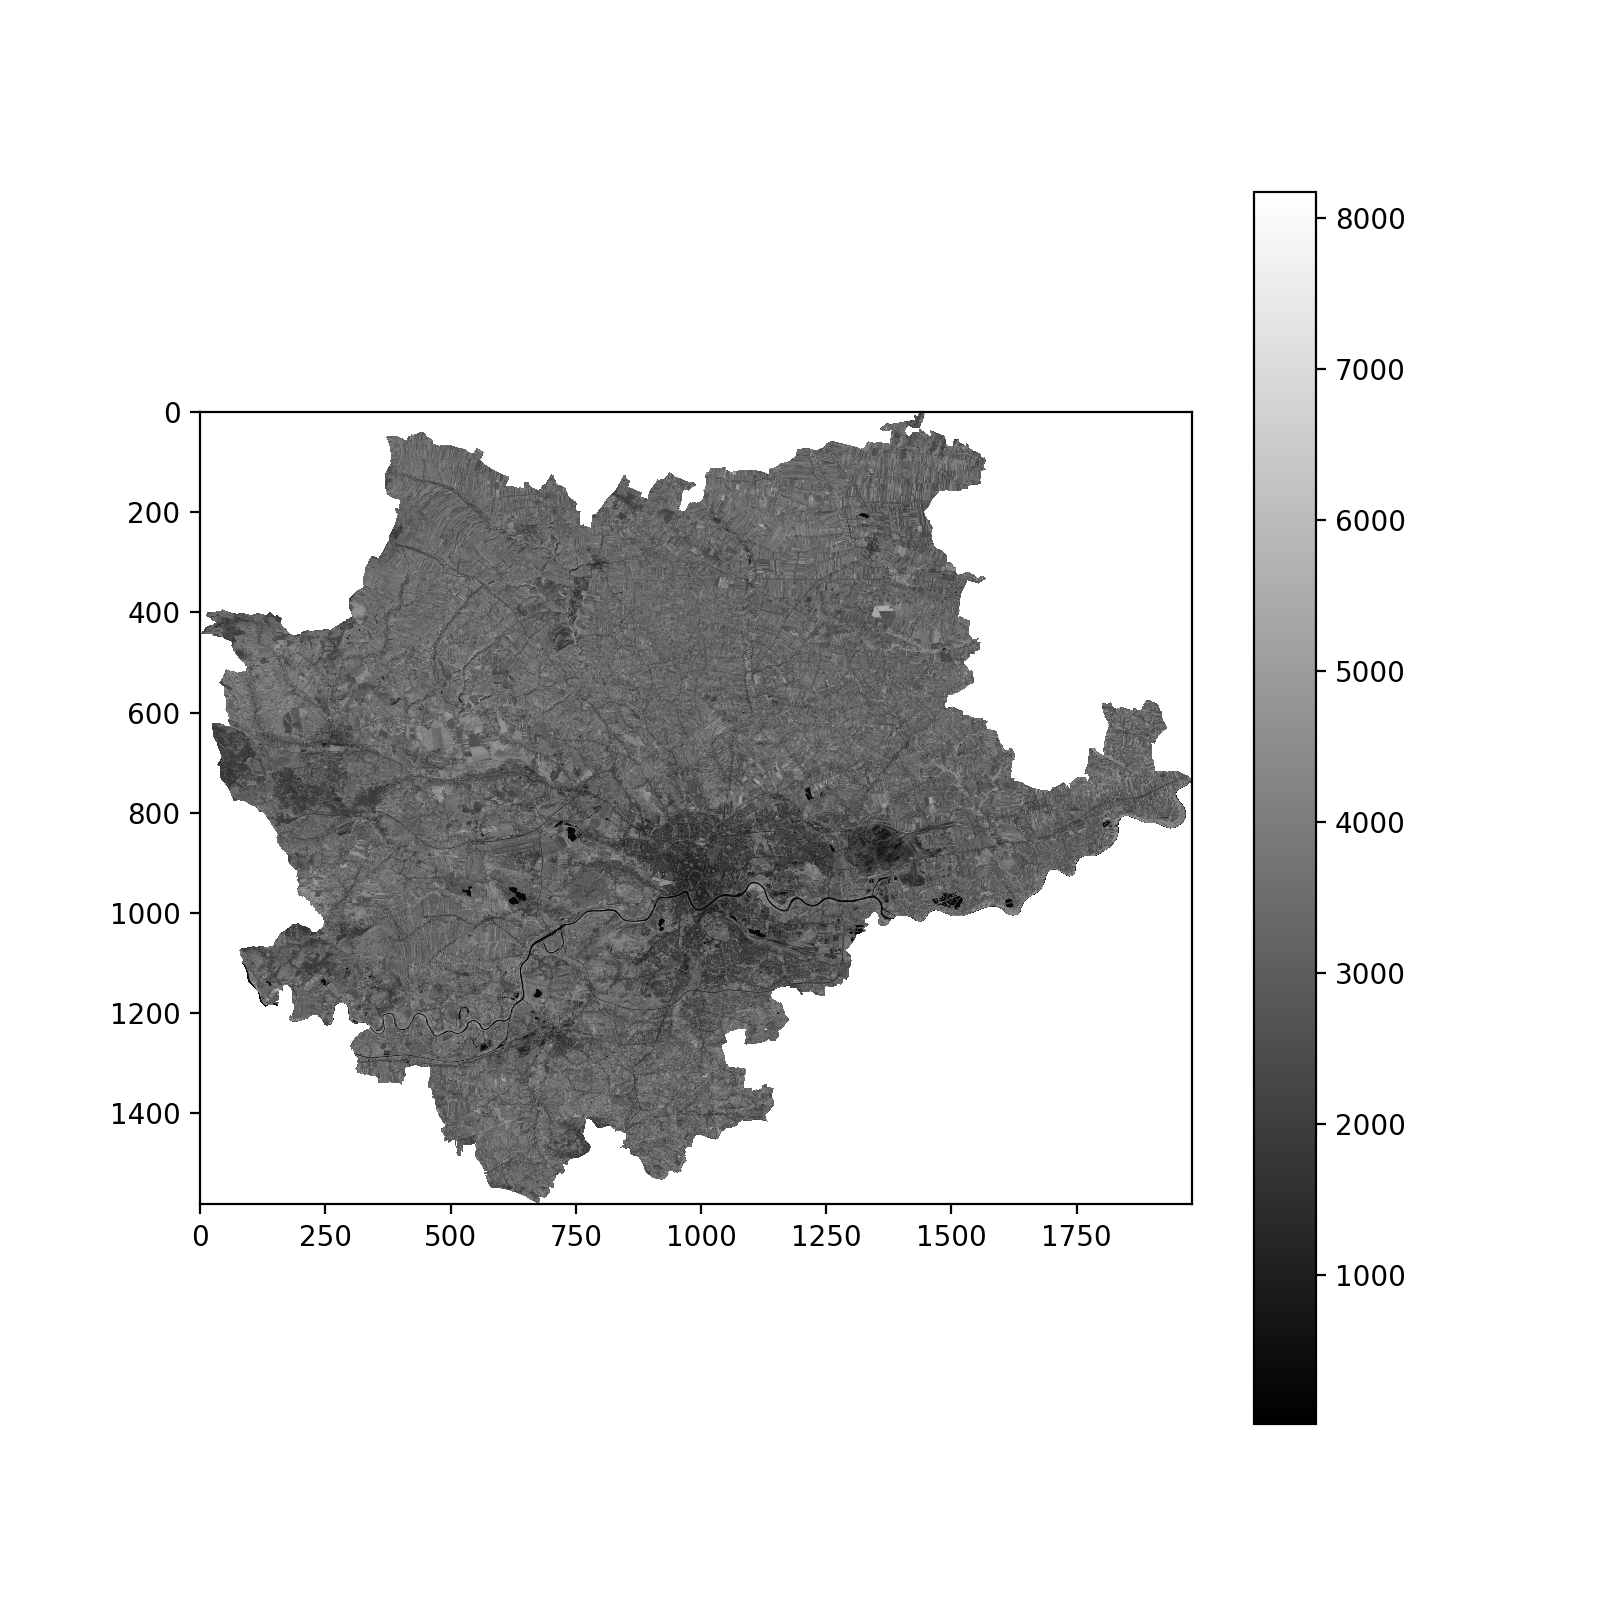

In [14]:
# 4. Wyświetlenie przykładowego pliku

with rio.open(lista_wycietych_obrazow[5], 'r') as src:
    macierz_kanalu = src.read(1)

wyswietl_obraz(macierz_kanalu)

## Obraz w formacie RGB - "przyjazny" dla ludzkiego oka

Wycięcie obrazów do obszaru zainteresowania to pierwszy krok "poważnej" analizy zdjęć satelitarnych. Zanim przejdziemy dalej, skoncentrujemy się jeszcze na trikach istotniejszych dla osób pracujących z GUI, a mianowicie na wyświetleniu zdjęcia w formacie RGB.

By to zrobić musimy nałożyć na siebie 3 kanały: kanał R - czerwony, kanał G - zielony i kanał B - niebieski, gdzie:
* R: kanał 4 satelity Landsat 8
* G: kanał 3 satelity Landsat 8
* B: kanał 2 satelity Landsat 8

Do złożenia kanałów w całość wykorzystamy bibliotekę numpy. Za złożenie obrazu odpowiedzialna będzie funkcja wyświetlająca dane kanały.

<IPython.core.display.Javascript object>


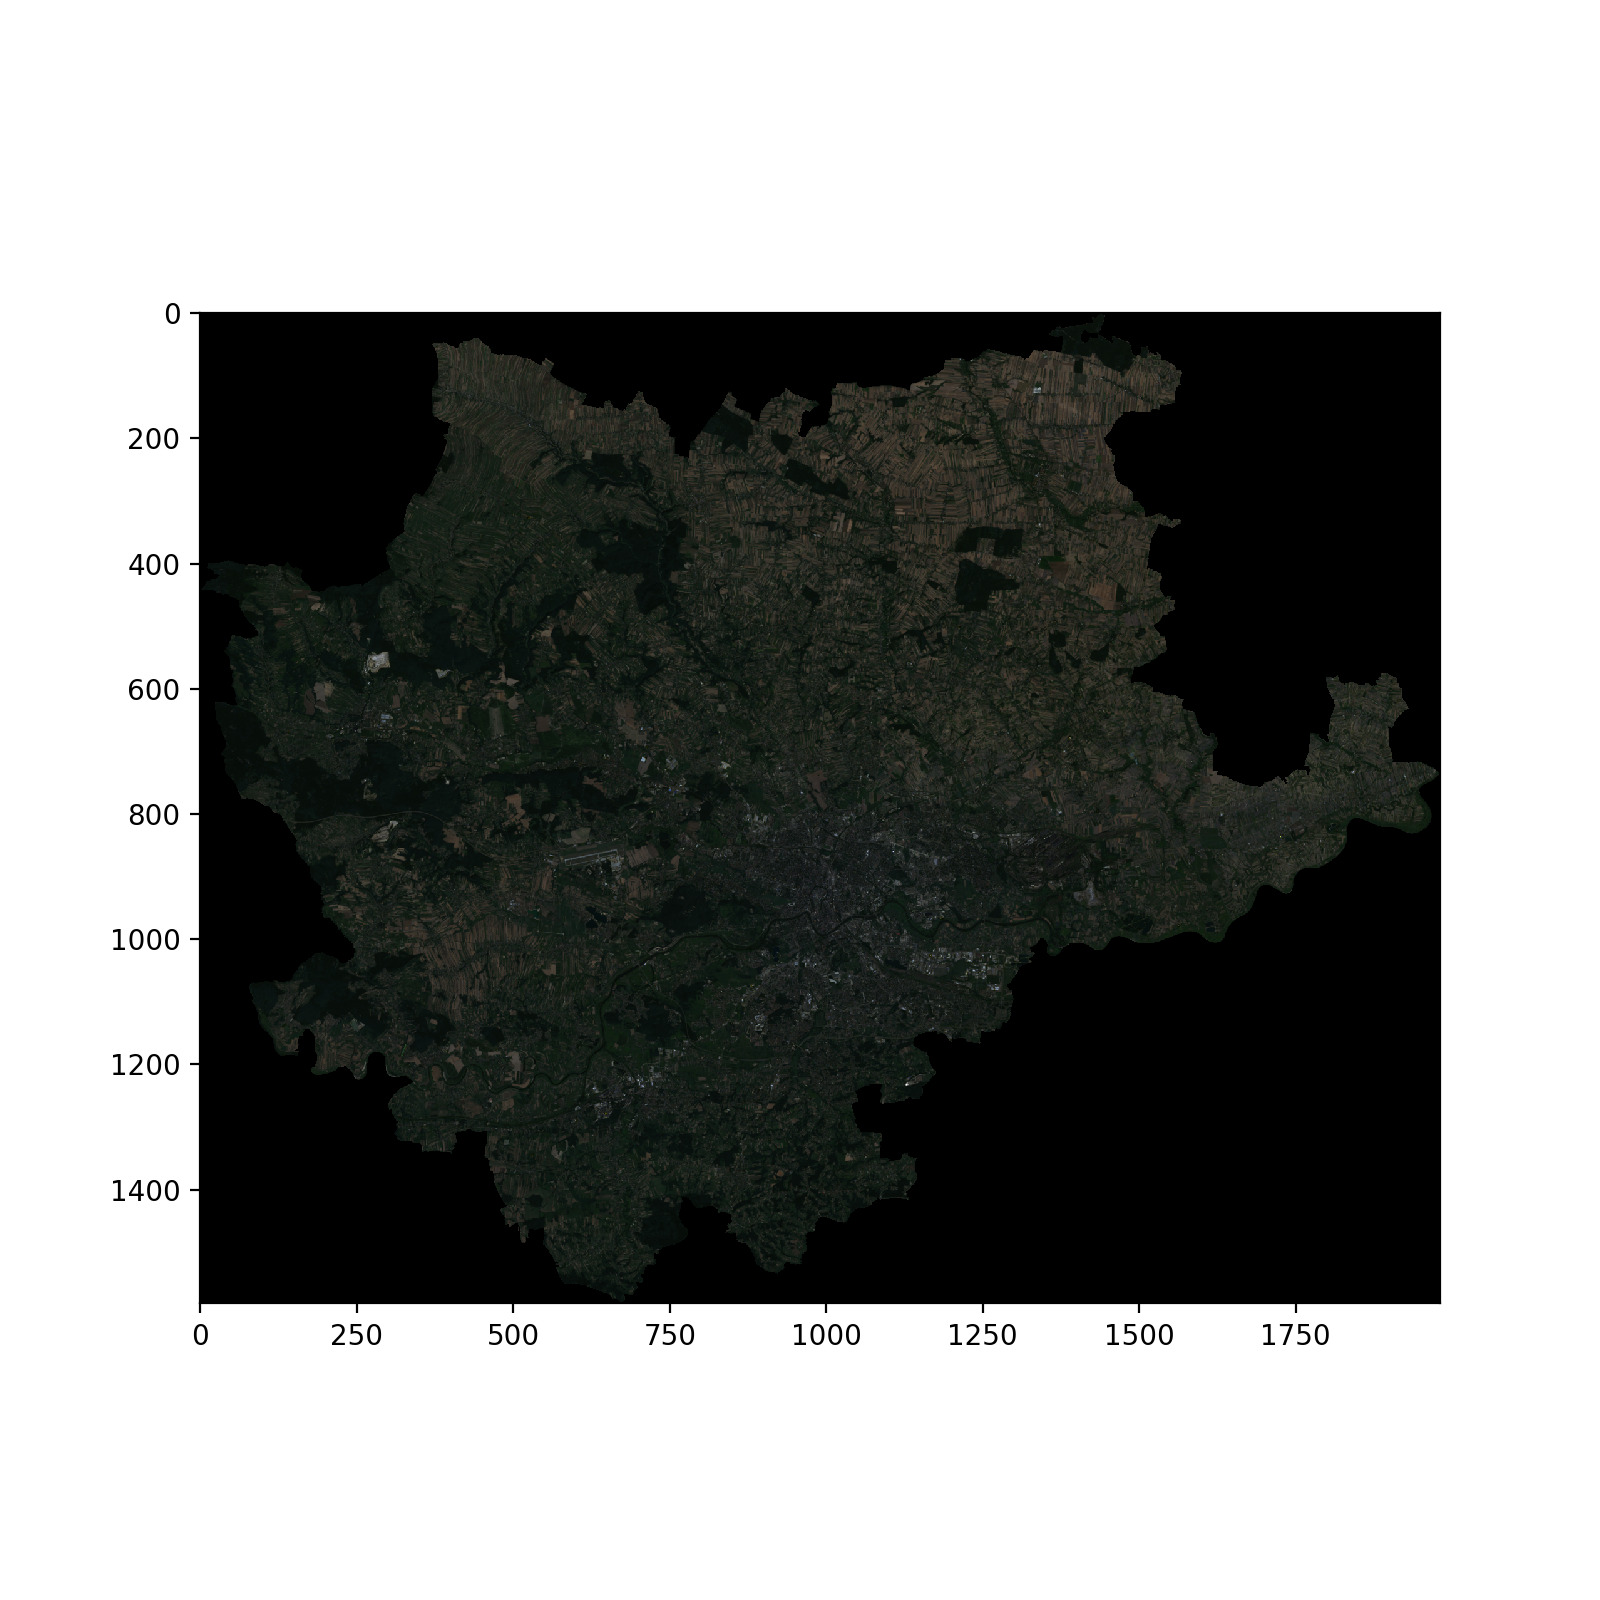

In [24]:
def wyswietl_rgb(slownik_z_adresami_plikow):
    with rio.open(slownik_z_adresami_plikow[4], 'r') as k_czerwony:
        R = k_czerwony.read()[0]
    with rio.open(slownik_z_adresami_plikow[3], 'r') as k_zielony:
        G = k_zielony.read()[0]
    with rio.open(slownik_z_adresami_plikow[2], 'r') as k_niebieski:
        B = k_niebieski.read()[0]
    RGB = np.dstack((R/np.max(R),
                     G/np.max(G),
                     B/np.max(B))).astype(np.float32)
    RGB[RGB < 0] = np.nan
    fig = plt.figure(figsize=(8,8))
    plt.imshow(RGB)
    
wyswietl_rgb(lista_wycietych_obrazow)

Obraz jest mocno przyciemniony... By doprowadzić go do używalności należałoby skorzystać z technik przetwarzania obrazów takich jak "contrast stretching", co polecam zrobić - w ramach tego tutoriala nie będziemy się tym zajmować, ponieważ wykracza to znacznie poza jego zakres.

## Obliczanie wskaźników

Teraz przejdziemy do najważniejszej części poradnika: obliczeń wskaźników używanych w obserwacjach Ziemi. Więcej na ich temat w artykule, tutaj tylko informacja o wskaźnikach, które będziemy obliczać:

* NDVI - Znormalizowany różnicowy wskaźnik wegetacji -> NDBI = (B5 - B4) / (B5 + B4)
* NDBI - Znormalizowany różnicowy wskaźnik zabudowy -> NDBI = (B6 - B5) / (B6 + B5)
* NDWI